<div style="background-color:rgba(78, 188, 130, 0.05); text-align:center; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(78, 188, 130, 1.0); color: #000000;">

<img src="figs/qr_logo.png" width="700"/>

<h1><strong>Quantum Summer School</strong></h1>

<h2><strong>Episode 8</strong></h2>

<h3><strong>Quantum Fourier Transform & Quantum Phase Estimation</strong></h3>

</div>

*In this session, we’ll learn the Quantum Fourier Transform and use it to perform Quantum Phase Estimation.*

<div style="background-color:rgba(255, 248, 240, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(255, 142, 0, 1.0); color: #000000;">

## Objectives
1. Explore classical Fourier transform
2. Understand the quantum Fourier transform
3. Run the Quantum Phase Estimation Algorithm

<div/>

## Setup & Imports

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.circuit.library import QFT as qkQFT
from qiskit.visualization import plot_histogram
from quantumrings.toolkit.qiskit import QrBackendV2, QrSamplerV1
from QuantumRingsLib import QuantumRingsProvider
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as sp

# Provider & backend (toolkit)
provider = QuantumRingsProvider()
backend = QrBackendV2(provider, num_qubits=2)

# Helper Functions

Functions to convert a decimal to binary fractions (ex. 1/10 --> 0.00011), and convert a binary number to an integer (ex. 10 --> 2).

In [85]:
def decimal_to_binary_fraction(x, bits=20):

    binary = "0."
    for _ in range(bits):
        x *= 2
        if x >= 1:
            binary += "1"
            x -= 1
        else:
            binary += "0"

    return binary

def binary_to_int(binary):
    return int(binary, 2)

def binary_conversion(fraction):
    binary_fraction = decimal_to_binary_fraction(fraction, bits=5)
    integer = binary_to_int(binary_fraction[2:])
    print(f'We expect to measure {binary_fraction}, which corresponds to basis state k={integer}')

# 1. Classical Fourier Transform

<div style="background-color:rgba(255, 245, 253, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(255, 142, 235, 1.0); color: #000000;">

The Fourier transform is a function which transforms us between two different domains. Two common examples are the time and frequency domains, and the position and momentum domains. The Fourier tranform is a very powerful mathematical tool. For example, if we have an audio signal (which is amplitude of noise in the time domain), we can apply the Fourier transform to find out what frequencies exist within the signal. This can be used for applications like voice recognition, since the frequency composition of phonetic sounds can decipher speech. Other examples include ECGs (electrocardiograms), where the Fourier transform can detect abnormalities in heartbeat rhythm. 

The Fourier transform is also very powerful in quantum computing, because it can be used to detect periodicity. The quantum Fourier tranform (QFT) is an essential component in Shor's factoring algorithm and many other foundational quantum algorithms. Before we build the QFT, let's first play around with the classical Fourier transform.

Mathematically, the Fourier transform maps a vector $\vec{x} = (x_0,x_1,\cdots x_{N-1})$ to another vector $FT(\vec{x}) = \vec{y} = (y_0,y_1,\cdots y_{N-1})$, where:

$$ y_k = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} e^{-2\pi i k j/N} x_j$$

The inverse Fourier transform maps in the opposite direction, so $IFT(\vec{y}) = \vec{x}$, and this corresponds to:

$$ x_k = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} e^{2\pi i k j/N} y_j$$

<div/>

### A sine wave signal

Let's make a sine wave signal (in the time domain), and then apply the FT.

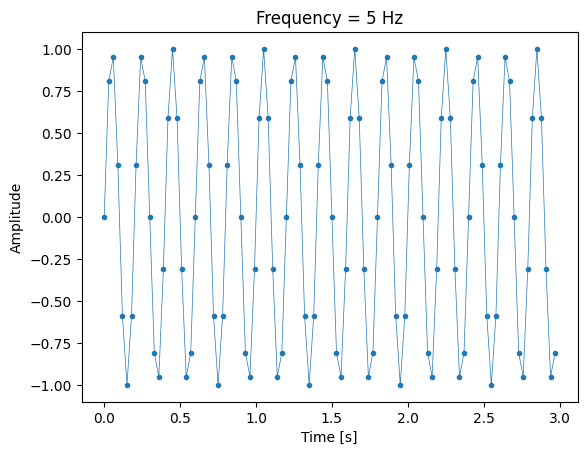

In [15]:
# frequency in Hz
frequency = 5

# duration of measurement and samples
duration = 3
samples = 100
sample_rate = samples / duration

x = np.linspace(0, duration, samples, endpoint=False)

# sine wave at given frequency
y = np.sin(2 * np.pi * frequency * x)

plt.plot(x,y, '.', ls='-', lw=0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title(f'Frequency = {round(frequency,2)} Hz')
plt.show()

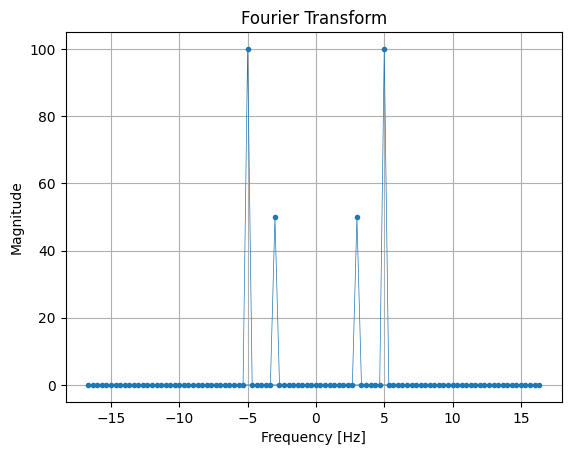

In [31]:
# fourier transform
Y = sp.fft(y)
freqs = sp.fftfreq(samples, 1/sample_rate)

plt.plot(freqs, np.abs(Y), '.', ls='-', lw=0.5)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Fourier Transform')
plt.grid(True)
plt.show()

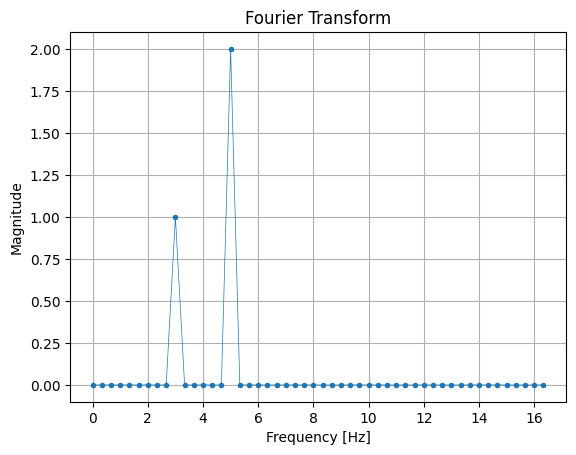

In [30]:
# plot the positive half
half = samples//2
plt.plot(freqs[:half], np.abs(Y[:half]) * 2 / samples, '.', ls='-', lw=0.5)  # Normalize amplitude
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Fourier Transform')
plt.grid(True)
plt.show()

### A sum of sines

We can also make a signal with two different frequencies in it.

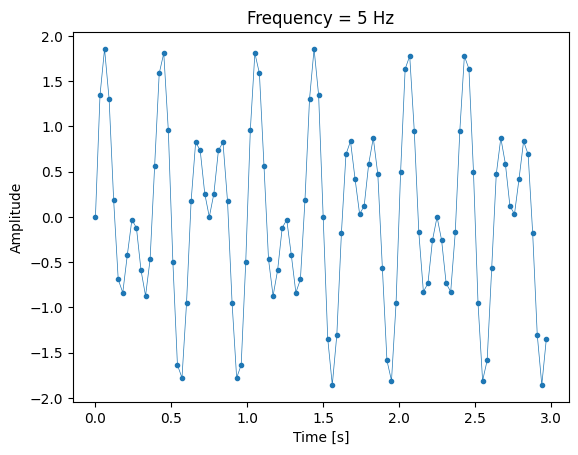

In [28]:
# frequencies in Hz
freq1 = 5
freq2 = 3

# duration of measurement and samples
duration = 3
samples = 100
sample_rate = samples / duration

x = np.linspace(0, duration, samples, endpoint=False)
y = np.sin(2 * np.pi * freq1 * x) + np.sin(2 * np.pi * freq2 * x)

plt.plot(x,y, '.', ls='-', lw=0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title(f'Frequency = {round(frequency,2)} Hz')
plt.show()

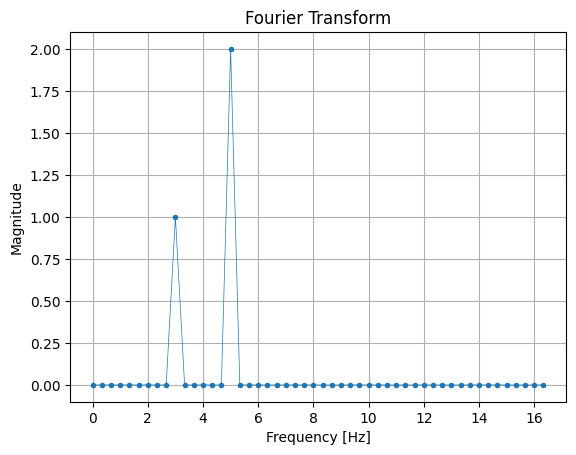

In [32]:
# fourier transform
Y = sp.fft(y)
freqs = sp.fftfreq(samples, 1/sample_rate)

# plot the positive half
half = samples//2
plt.plot(freqs[:half], np.abs(Y[:half]) * 2 / samples, '.', ls='-', lw=0.5)  # Normalize amplitude
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Fourier Transform')
plt.grid(True)
plt.show()

**Question:** What happens if we change the relative amplitude of the two sine waves?

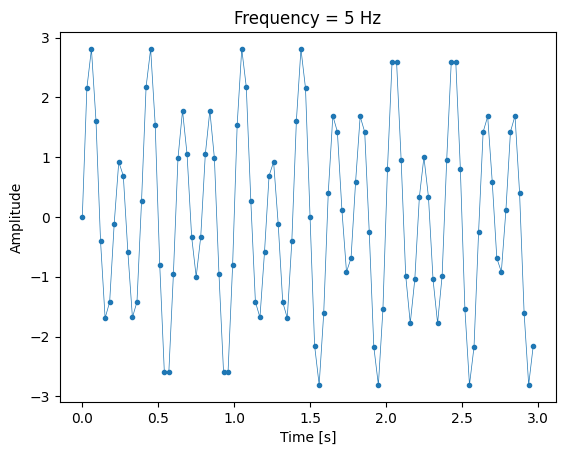

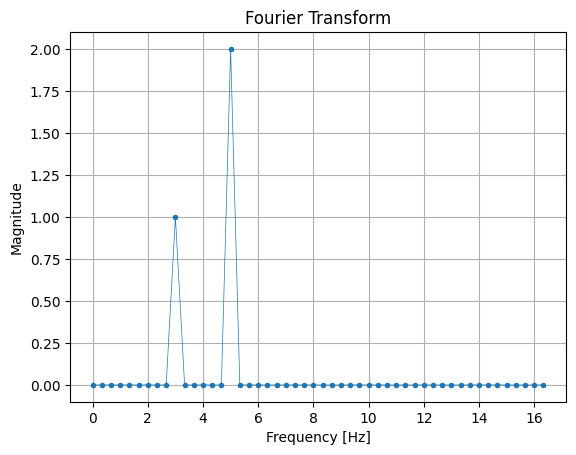

In [33]:
# frequencies in Hz
freq1 = 5
freq2 = 3

# duration of measurement and samples
duration = 3
samples = 100
sample_rate = samples / duration

x = np.linspace(0, duration, samples, endpoint=False)
y = 2*np.sin(2 * np.pi * freq1 * x) + np.sin(2 * np.pi * freq2 * x)

plt.plot(x,y, '.', ls='-', lw=0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title(f'Frequency = {round(frequency,2)} Hz')
plt.show()

# fourier transform
Y = sp.fft(y)
freqs = sp.fftfreq(samples, 1/sample_rate)

# plot the positive half
half = samples//2
plt.plot(freqs[:half], np.abs(Y[:half]) * 2 / samples, '.', ls='-', lw=0.5)  # Normalize amplitude
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Fourier Transform')
plt.grid(True)
plt.show()

<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

Explore and answer the following questions:
* What happens if you increase or decrease the duration of sampling?
* What happens if you increase or decrease the number of samples?
* What can you say about the relationship between the choice of duration and choice of number of samples?

<div/>

In [ ]:
## your code here

### Adding Noise

In real life, we don't have perfect sine wave signals. What happens if we have "real life data" with noise in it?

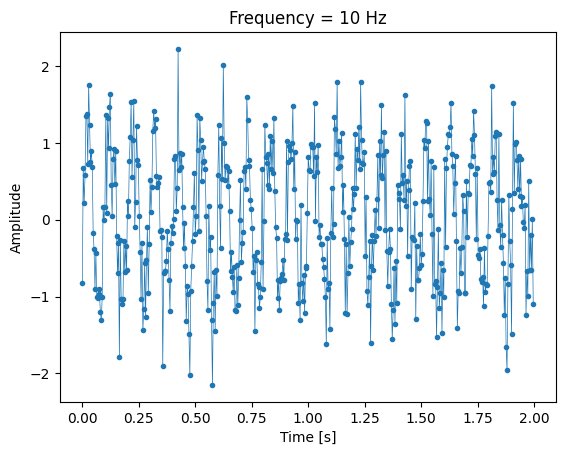

In [35]:
frequency = 10

duration = 2
samples = 500
sample_rate = samples / duration

x = np.linspace(0, duration, samples, endpoint=False)

# random normal noise
noise = np.random.normal(0,0.5,len(x))

y = np.sin(2 * np.pi * frequency * x) + noise

plt.plot(x,y, '.', ls='-', lw=0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title(f'Frequency = {round(frequency,2)} Hz')
plt.show()

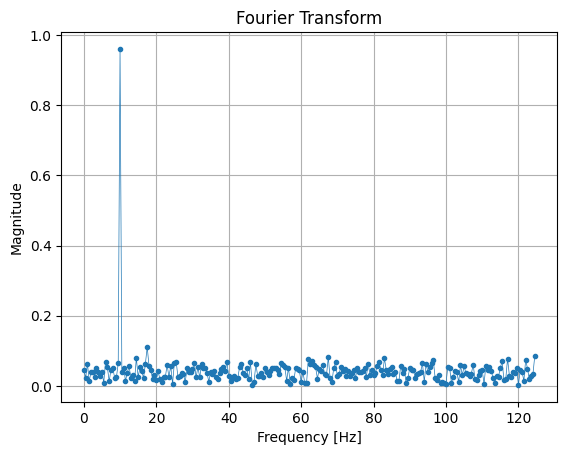

In [36]:
# fourier transform
Y = sp.fft(y)
freqs = sp.fftfreq(samples, 1/sample_rate)

# plot the positive half
half = samples//2
plt.plot(freqs[:half], np.abs(Y[:half]) * 2 / samples, '.', ls='-', lw=0.5)  # Normalize amplitude
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Fourier Transform')
plt.grid(True)
plt.show()

<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

Make a signal which is a square pulse (only non zero in a finite time $t_1 \leq t \leq t_2$). What does the Fourier transform of that look like? How does it change as you change the duration of the square pulse?

<div/>

In [ ]:
## your code here

# 2. Quantum Fourier Transform

<div style="background-color:rgba(236, 250, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(35, 175, 219, 1.0); color: #000000;">

The QFT is very similar to the classical FT except that the vector that the QFT is acting on is the amplitude of bitstrings. Mathematically, for an n-bit register with $|x\rangle = \sum_{j=0}^{2^n-1} c_{x,j} |j\rangle$, we have $QFT|x\rangle = |y\rangle= \sum_{k=0}^{2^n-1} c_{y,k} |k\rangle$ where:

$$ c_{y,k} = \frac{1}{2^n} \sum_{j=0}^{2^n-1} c_{x,j} $$

The action of the QFT on a basis state $|x\rangle = |x_1 x_2 \cdots x_n\rangle$ with $x_j\in\{0,1\}$ is:

$$ QFT|x\rangle = \frac{1}{2^n} ( |0\rangle + e^{2\pi i [0.x_n]} |1\rangle) \otimes ( |0\rangle + e^{2\pi i [0.x_{n-1}x_n]} |1\rangle) \otimes \cdots \otimes ( |0\rangle + e^{2\pi i [0.x_1\cdots x_n]} |1\rangle)$$

where $[0.x_1\cdots x_m]$ is a binary fraction. Practically speaking, this means each qubit experiences a unitary which involves a Hadamard gate and then controlled phase rotations with increasingly smaller rotation angles. For $n=3$ it looks like this:

<img src="figs/qft.jpg" width="700"/>

<div/>

In [39]:
num_qubits = 3

qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)

for i in range(0, num_qubits):
    qc.h(i)

    for j in range(i+1,num_qubits,1):
        denominator = 2**(j-i)
        qc.cp(np.pi/denominator, j,i)
    qc.barrier()

qc.draw()

┌───┐                   ░                ░       ░ 
q0_0: ┤ H ├─■────────■────────░────────────────░───────░─
      └───┘ │P(π/2)  │        ░ ┌───┐          ░       ░ 
q0_1: ──────■────────┼────────░─┤ H ├─■────────░───────░─
                     │P(π/4)  ░ └───┘ │P(π/2)  ░ ┌───┐ ░ 
q0_2: ───────────────■────────░───────■────────░─┤ H ├─░─
                              ░                ░ └───┘ ░

Let's turn this into a function we can use later:

In [40]:
def QFT(num_qubits):
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    
    ###
    for i in range(0, num_qubits):
        qc.h(i)
    
        for j in range(i+1,num_qubits,1):
            denominator = 2**(j-i)
            qc.cp(np.pi/denominator, j,i)
        qc.barrier()

    return qc

In [42]:
num_qubits = 3
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)

qc.compose(QFT(num_qubits),inplace=True)
display(qc.draw())

┌───┐                   ░                ░       ░ 
q3_0: ┤ H ├─■────────■────────░────────────────░───────░─
      └───┘ │P(π/2)  │        ░ ┌───┐          ░       ░ 
q3_1: ──────■────────┼────────░─┤ H ├─■────────░───────░─
                     │P(π/4)  ░ └───┘ │P(π/2)  ░ ┌───┐ ░ 
q3_2: ───────────────■────────░───────■────────░─┤ H ├─░─
                              ░                ░ └───┘ ░

What about the inverse QFT?

In [43]:
num_qubits = 3
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)

IQFT = QFT(num_qubits).inverse()

qc.compose(IQFT,inplace=True)
display(qc.draw())

░       ░                 ░                     ┌───┐
q5_0: ─░───────░─────────────────░──■─────────■────────┤ H ├
       ░       ░           ┌───┐ ░  │         │P(-π/2) └───┘
q5_1: ─░───────░──■────────┤ H ├─░──┼─────────■─────────────
       ░ ┌───┐ ░  │P(-π/2) └───┘ ░  │P(-π/4)                
q5_2: ─░─┤ H ├─░──■──────────────░──■───────────────────────
       ░ └───┘ ░                 ░

# 3. Quantum Phase Estimation


<div style="background-color:rgba(247, 255, 245, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(0, 153, 51, 1.0); color: #000000;">

In the same way the classical Fourier transform can detect periodicity in a time domain signal, the QFT can detect periodicity in the amplitudes of the basis states. Recall that if $|x\rangle = \sum_{j=0}^{2^n-1} c_{x,j} |j\rangle$, then $QFT|x\rangle = |y\rangle= \sum_{k=0}^{2^n-1} c_{y,k} |k\rangle$ where:

$$ c_{y,k} = \frac{1}{2^n} \sum_{j=0}^{2^n-1} c_{x,j} $$

If there is an underlying frequency/frequencies in the amplitudes $\{ c_{x,j} \}$, then that will be reflected in the resulting amplitudes $\{ c_{y,k} \}$.

Choose a period $T\in \mathbb{Z}$. Suppose we prepare the state:
$$|\psi\rangle= \frac{1}{2^n} \sum_{x=0}^{2^n-1} e^{2\pi i x/T} |x\rangle$$

There is clearly periodicity in the amplitudes of $|\psi\rangle$. We won't work out the math here, but if you apply the IQFT to $|\psi\rangle$, you will with high probability measure $|x_1 x_2 \cdots x_n \rangle$ which satisfy $1/T \approx [0.x_1 x_2 \cdots x_n]$. In other words, the measurement result is an n-bit approximation of the reciprocal of the periodicity.

What we have just described in usually phrased in different terms and is called Quantum Phase Estimation. In QPE, as the name implies, we want to estimate a phase $\theta$. We can prepare the initial state:

$$ QFT |\theta\rangle = \frac{1}{2^n} \sum_{x=0}^{2^n-1} e^{2\pi i\theta x} |x\rangle $$

Note that $|\theta\rangle$ is the n-bit approximation of $\theta \in [0,1)$. For example, in a 3-qubit register, if $\theta = 3/4$, then $|\theta\rangle = |110\rangle$, because: 

$$\theta = [0.110] = 1\cdot 2^{-1} + 1\cdot 2^{-2} + 0\cdot 2^{-3}$$

For a number which cannot be exactly expressed in 3-bits, we just take the first three bits. For example, if $\theta = 1/7$, then $|\theta\rangle = |001\rangle$. In actuality, $0.001$ in binary is $0.125 = 1/8$.

If we apply $IQFT$ to $QFT |\theta\rangle$, we should get $|\theta\rangle$, and this is exactly how QPE works. Let's see how to construct $QFT |\theta\rangle$.

</div>

### Building the initial state

We want to make:

$$ QFT |\theta\rangle = \frac{1}{2^n} \sum_{x=0}^{2^n-1} e^{2\pi i\theta x} |x\rangle $$

We can start by applying a Hadamard gate to every qubit, which puts us in the equal superposition state of all bitstrings of length n: 
$$\frac{1}{2^n} \sum_{x=0}^{2^n-1}  |x\rangle$$

Then we want to acquire a phase $\theta k$ on the basis state $k$. We can accomplish this by applying a controlled phase $\theta \cdot2^j$ on the jth qubit. This will work because we know that $k = \sum_{j=1} ^n x_j \cdot 2^j$, so everywhere there is a 1 in k, we want to apply the phase $\theta \cdot2^j$. Let's build this together. 

NOTE:We will need an auxillary qubit to apply our controlled phase rotations.

In [62]:
def prep_state(num_qubits, theta):

    qr = QuantumRegister(num_qubits+1)
    qc = QuantumCircuit(qr)
    
    qc.x(num_qubits)
    
    qc.h(range(0,num_qubits))

    # for j in range(num_qubits-1, -1,-1):
    for j in range(0, num_qubits):
        qc.cp(2*np.pi * 2**j * theta ,j,num_qubits)
    
    qc.x(num_qubits)

    return qc

In [75]:
num_qubits = 5
theta = 0.1
qr = QuantumRegister(num_qubits+1)
cr = ClassicalRegister(num_qubits)
qc = QuantumCircuit(qr,cr)

qc.compose(prep_state(num_qubits,theta),inplace=True)
display(qc.draw())

┌───┐                                                       
q39_0: ┤ H ├─■─────────────────────────────────────────────────────
       ├───┤ │                                                     
q39_1: ┤ H ├─┼────────■────────────────────────────────────────────
       ├───┤ │        │                                            
q39_2: ┤ H ├─┼────────┼─────────■──────────────────────────────────
       ├───┤ │        │         │                                  
q39_3: ┤ H ├─┼────────┼─────────┼─────────■────────────────────────
       ├───┤ │        │         │         │                        
q39_4: ┤ H ├─┼────────┼─────────┼─────────┼─────────■──────────────
       ├───┤ │P(π/5)  │P(2π/5)  │P(4π/5)  │P(8π/5)  │P(16π/5) ┌───┐
q39_5: ┤ X ├─■────────■─────────■─────────■─────────■─────────┤ X ├
       └───┘                                                  └───┘
c16: 5/════════════════════════════════════════════════════════════

We can plot the real part of the wavefunction to see the periodicity!

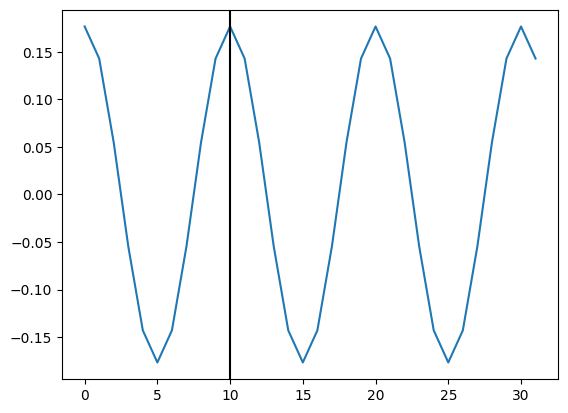

In [79]:
sv = Statevector.from_instruction(qc)
plt.plot(np.real(sv)[:int(2**num_qubits)])
plt.axvline(1/theta, color='k')
plt.show()

In [88]:
num_qubits = 5
theta = 0.1

binary_conversion(theta)

qr = QuantumRegister(num_qubits+1)
cr = ClassicalRegister(num_qubits)
qc = QuantumCircuit(qr,cr)

qc.compose(prep_state(num_qubits,theta),inplace=True)
qc.barrier()

iQFT = QFT(num_qubits).inverse()
qc.compose(iQFT,inplace=True)

qc.barrier()

# we need to flip bit ordering to match convention
qc.measure(qr[:-1][::-1],cr)
qc.draw()

We expect to measure 0.00011, which corresponds to basis state k=3


┌───┐                                                        ░  ░      »
q53_0: ┤ H ├─■──────────────────────────────────────────────────────░──░──────»
       ├───┤ │                                                      ░  ░      »
q53_1: ┤ H ├─┼────────■─────────────────────────────────────────────░──░──────»
       ├───┤ │        │                                             ░  ░      »
q53_2: ┤ H ├─┼────────┼─────────■───────────────────────────────────░──░──────»
       ├───┤ │        │         │                                   ░  ░      »
q53_3: ┤ H ├─┼────────┼─────────┼─────────■─────────────────────────░──░──────»
       ├───┤ │        │         │         │                         ░  ░ ┌───┐»
q53_4: ┤ H ├─┼────────┼─────────┼─────────┼─────────■───────────────░──░─┤ H ├»
       ├───┤ │P(π/5)  │P(2π/5)  │P(4π/5)  │P(8π/5)  │P(16π/5) ┌───┐ ░  ░ └───┘»
q53_5: ┤ X ├─■────────■─────────■─────────■─────────■─────────┤ X ├─░─────────»
       └───┘                                                  └───┘ ░         »
c21: 5/═══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ░                 ░                           ░                     »
«q53_0: ─░─────────────────░───────────────────────────░─────────────────────»
«        ░                 ░                           ░                     »
«q53_1: ─░─────────────────░───────────────────────────░──■─────────■────────»
«        ░                 ░                     ┌───┐ ░  │         │        »
«q53_2: ─░─────────────────░──■─────────■────────┤ H ├─░──┼─────────┼────────»
«        ░           ┌───┐ ░  │         │P(-π/2) └───┘ ░  │         │P(-π/4) »
«q53_3: ─░──■────────┤ H ├─░──┼─────────■──────────────░──┼─────────■────────»
«        ░  │P(-π/2) └───┘ ░  │P(-π/4)                 ░  │P(-π/8)           »
«q53_4: ─░──■──────────────░──■────────────────────────░──■──────────────────»
«        ░                 ░                           ░                     »
«q53_5: ─────────────────────────────────────────────────────────────────────»
«                                                                            »
«c21: 5/═════════════════════════════════════════════════════════════════════»
«                                                                            »
«                       ░                                          ┌───┐ ░    »
«q53_0: ────────────────░──■──────────■─────────■─────────■────────┤ H ├─░────»
«                 ┌───┐ ░  │          │         │         │P(-π/2) └───┘ ░    »
«q53_1: ─■────────┤ H ├─░──┼──────────┼─────────┼─────────■──────────────░────»
«        │P(-π/2) └───┘ ░  │          │         │P(-π/4)                 ░    »
«q53_2: ─■──────────────░──┼──────────┼─────────■────────────────────────░────»
«                       ░  │          │P(-π/8)                           ░    »
«q53_3: ────────────────░──┼──────────■──────────────────────────────────░────»
«                       ░  │P(-π/16)                                     ░ ┌─┐»
«q53_4: ────────────────░──■─────────────────────────────────────────────░─┤M├»
«                       ░                                                ░ └╥┘»
«q53_5: ─────────────────────────────────────────────────────────────────░──╫─»
«                                                                        ░  ║ »
«c21: 5/════════════════════════════════════════════════════════════════════╩═»
«                                                                           0 »
«                ┌─┐
«q53_0: ─────────┤M├
«             ┌─┐└╥┘
«q53_1: ──────┤M├─╫─
«          ┌─┐└╥┘ ║ 
«q53_2: ───┤M├─╫──╫─
«       ┌─┐└╥┘ ║  ║ 
«q53_3: ┤M├─╫──╫──╫─
«       └╥┘ ║  ║  ║ 
«q53_4: ─╫──╫──╫──╫─
«        ║  ║  ║  ║ 
«q53_5: ─╫──╫──╫──╫─
«        ║  ║  ║  ║ 
«c21: 5/═╩══╩══╩══╩═
«        1  2  3  4

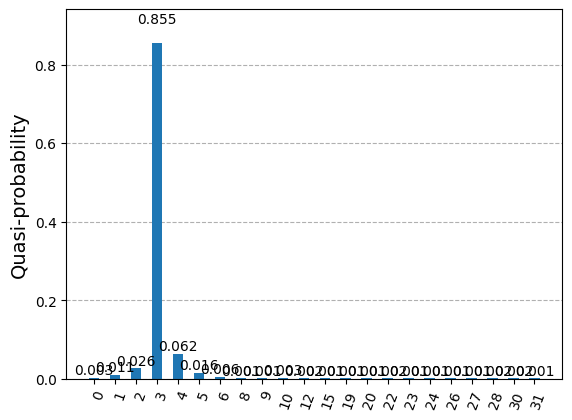

In [89]:
# Transpile for Quantum Rings
backend = QrBackendV2(provider, num_qubits=num_qubits+1)
qc_tp = transpile(qc, backend)

# Execute with toolkit sampler
sampler = QrSamplerV1(backend=backend)
job = sampler.run(circuits=[qc_tp])

counts = job.result().quasi_dists[0]
plot_histogram(counts)

<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

# Bonus Challenge: QPE with two phases

**Step 1:** Create a state preparation circuit which prepares an equal superposition of $|\psi_1\rangle = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n} e^{-2\pi i \theta_1 x } |x\rangle$ and $|\psi_2\rangle = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n} e^{-2\pi i \theta_2 x} |x\rangle$

HINT: You can use the prep_state() function we have already built. Leverage the Hadamard gate to apply prep_state(theta1) and prep_state(theta2) with equal probability.

**Step 2:** Run QPE. Do you measure $\theta_1$ and $\theta_2$?

<div/>

SECONDARY HINT: Just an H gate is not enough for Step 1. If you want to make a controlled unitary for an arbitrary gate, you can do this.

In [139]:
def my_gate(num_qubits):
    
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    
    qc.h(0)
    
    qc.cx(0,1)

    return qc

In [142]:
num_qubits = 4
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
qc.compose(my_gate(num_qubits),inplace=True)

# the argument of control is the number of controls for the gate
custom_controlled_gate = qc.to_gate().control(num_ctrl_qubits=1)

# use our custom gate
qr = QuantumRegister(num_qubits+1)
qc = QuantumCircuit(qr)
# first num_ctrl_qubits qubits will be the controls
qc.append(custom_controlled_gate, [4,0,1,2,3])
qc.draw()

┌──────────────┐
q186_0: ┤0             ├
        │              │
q186_1: ┤1             ├
        │  circuit-675 │
q186_2: ┤2             ├
        │              │
q186_3: ┤3             ├
        └──────┬───────┘
q186_4: ───────■────────